In [1]:
import imp
import numpy as np
import pandas as pd
import xgboost as xgb
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator
import xgboost as xgb

In [2]:
problem = imp.load_source('', 'problem.py')
X_df, y_array = problem.get_train_data()
X_df.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [3]:
ext_data = pd.read_csv('submissions/starting_kit/external_data.csv', sep=';')
ext_data.head()

,Departure,Arrival,Distance,DateOfDeparture,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Number_hab,Revenue,Oil_price,dep_encod,ar_encod
0,LAS,ORD,2434,2011-09-01,34,28,22,23,22,19,84,70,56,1015,1013,1011,16,15,11,26,9,37.0,0,1,NaN,197,2712920,52273,88.930000,10.76,11.26
1,LAS,ORD,2434,2011-09-02,33,29,24,22,21,19,79,64,49,1013,1012,1011,16,15,11,27,12,37.0,0,4,NaN,215,2712920,52273,86.570000,10.76,11.26
2,LAS,ORD,2434,2011-09-03,32,26,21,22,20,18,93,70,46,1013,1012,1011,16,15,8,32,10,39.0,0.51,6,Rain-Thunderstorm,270,2712920,52273,93.794367,10.76,11.26
3,LAS,ORD,2434,2011-09-04,23,19,14,19,13,9,93,70,47,1017,1013,1010,16,16,16,35,19,45.0,0,5,NaN,312,2712920,52273,93.794367,10.76,11.26
4,LAS,ORD,2434,2011-09-05,18,15,11,10,7,6,77,64,51,1021,1020,1017,16,16,16,42,24,56.0,0,3,NaN,5,2712920,52273,83.520000,10.76,11.26


In [18]:
X_encoded = X_df
external_data = ext_data[['Departure', 'Arrival',  'Distance', 'DateOfDeparture',
                          'Max TemperatureC',  'Mean TemperatureC', 'Min TemperatureC',
                          'Dew PointC', 'MeanDew PointC', 'Min DewpointC', 'Max Humidity',
                          'Mean Humidity', 'Min Humidity', 'Max Sea Level PressurehPa',
                          'Mean Sea Level PressurehPa', 'Min Sea Level PressurehPa',
                          'Max VisibilityKm', 'Mean VisibilityKm', 'Min VisibilitykM',
                          'Max Wind SpeedKm/h', 'Mean Wind SpeedKm/h',
                          'dep_encod', 'ar_encod']]
X_encoded = pd.merge(
            X_encoded, external_data, how='left',
            left_on=['DateOfDeparture', 'Arrival', 'Departure'],
            right_on=['DateOfDeparture', 'Arrival', 'Departure'],
            sort=False)
X_encoded.drop(['std_wtd'], axis=1, inplace=True)
X_encoded.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,Distance,Mean TemperatureC,dep_encod,ar_encod
0,2012-06-19,ORD,DFW,12.875000,1292,29,11.27,11.08
1,2012-09-10,LAS,DEN,14.285714,1010,25,10.76,10.69
2,2012-10-05,DEN,LAX,10.863636,1387,19,10.68,11.43
3,2011-10-09,ATL,ORD,11.480000,977,19,11.00,11.26
4,2012-02-21,DEN,SFO,11.450000,1554,12,10.68,11.23


In [19]:
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure']))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
X_encoded = X_encoded.drop('Departure', axis=1)
X_encoded = X_encoded.drop('Arrival', axis=1)

X_encoded.loc[:, 'ATL': 'SFO'] = X_encoded.loc[:, 'ATL': 'SFO'].mul(X_encoded.loc[:, 'dep_encod'], axis='rows')
arr = X_encoded.loc[:, 'a_ATL': 'a_SFO'].mul(- 1 * X_encoded.loc[:, 'ar_encod'], axis='rows')

arr.columns = X_encoded.loc[:, 'ATL': 'SFO'].columns
X_encoded.loc[:, 'ATL': 'SFO'] = X_encoded.loc[:, 'ATL': 'SFO'].add(arr, axis=1)

X_encoded.drop(['dep_encod', 'ar_encod'], axis=1, inplace=True)
X_encoded.drop(X_encoded.loc[:, 'a_ATL': 'a_SFO'].columns, axis=1, inplace=True)
X_encoded.head()

,DateOfDeparture,WeeksToDeparture,Distance,Mean TemperatureC,ATL,BOS,CLT,DEN,DFW,DTW,EWR,IAH,JFK,LAS,LAX,LGA,MCO,MIA,MSP,ORD,PHL,PHX,SEA,SFO
0,2012-06-19,12.875000,1292,29,0.0,0.0,0.0,0.00,-11.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.27,0.0,0.0,0.0,0.00
1,2012-09-10,14.285714,1010,25,0.0,0.0,0.0,-10.69,0.00,0.0,0.0,0.0,0.0,10.76,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00
2,2012-10-05,10.863636,1387,19,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,-11.43,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00
3,2011-10-09,11.480000,977,19,11.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-11.26,0.0,0.0,0.0,0.00
4,2012-02-21,11.450000,1554,12,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,-11.23


In [20]:
X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))

X_encoded = X_encoded.drop(['DateOfDeparture', 'year', 'month', 'day', 'weekday', 'week'], axis=1)
X_encoded.head()

,WeeksToDeparture,Distance,Mean TemperatureC,ATL,BOS,CLT,DEN,DFW,DTW,EWR,IAH,JFK,LAS,LAX,LGA,MCO,MIA,MSP,ORD,PHL,PHX,SEA,SFO,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.875000,1292,29,0.0,0.0,0.0,0.00,-11.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.27,0.0,0.0,0.0,0.00,15510,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,1010,25,0.0,0.0,0.0,-10.69,0.00,0.0,0.0,0.0,0.0,10.76,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,15593,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,1387,19,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,-11.43,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,15618,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,977,19,11.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-11.26,0.0,0.0,0.0,0.00,15256,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,1554,12,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,-11.23,15391,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [127]:
from sklearn.decomposition import PCA 
from sklearn import preprocessing

reserv = preprocessing.scale(X_encoded.loc[:, 'WeeksToDeparture' : 'std_wtd'])
meteo = preprocessing.scale(X_encoded.loc[:, 'Max TemperatureC' : 'Min Humidity'])
pca = PCA(n_components=1)
reserv = pca.fit_transform(reserv)

pca = PCA(n_components=1)
meteo = pca.fit_transform(meteo)

In [128]:
meteo = pd.DataFrame(data = meteo, columns = ['Princ. Comp. ' + str(i) for i in range(1)])

X_encoded = pd.concat([X_encoded, meteo], axis = 1)
X_encoded['reserv'] = reserv
X_encoded.head()

In [130]:
X_encoded.drop(['WeeksToDeparture', 'std_wtd', 'Max TemperatureC', 'Mean TemperatureC', 'Min TemperatureC',
                          'Dew PointC', 'MeanDew PointC', 'Min DewpointC', 'Max Humidity',
                          'Mean Humidity', 'Min Humidity', 'Max Sea Level PressurehPa',
                          'Mean Sea Level PressurehPa', 'Min Sea Level PressurehPa',
                          'Max VisibilityKm', 'Mean VisibilityKm', 'Min VisibilitykM',
                          'Max Wind SpeedKm/h', 'Mean Wind SpeedKm/h'], axis=1, inplace=True)
X_encoded.head()

,Distance,ATL,BOS,CLT,DEN,DFW,DTW,EWR,IAH,JFK,LAS,LAX,LGA,MCO,MIA,MSP,ORD,PHL,PHX,SEA,SFO,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52,Princ. Comp. 0,reserv
0,1292,0.0,0.0,0.0,0.00,-11.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.27,0.0,0.0,0.0,0.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-3.684727,0.757354
1,1010,0.0,0.0,0.0,-10.69,0.00,0.0,0.0,0.0,0.0,10.76,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.671091,1.000951
2,1387,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,-11.43,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-2.276192,-0.009688
3,977,11.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-11.26,0.0,0.0,0.0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1.026197,-0.198907
4,1554,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,-11.23,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.538699,0.298146


In [219]:
X_encoded['Events'].fillna(0, inplace=True)
X_encoded['Events'] = X_encoded['Events'].replace(['Rain','Fog'], 1)
X_encoded['Events'] = X_encoded['Events'].replace(['Rain-Thunderstorm','Fog-Rain-Thunderstorm', \
                                                        'Rain-Snow','Snow','Fog-Rain','Thunderstorm','Fog-Snow', \
                                                        'Fog-Rain-Snow','Fog-Rain-Snow-Thunderstorm', \
                                                        'Rain-Snow-Thunderstorm','Rain-Hail-Thunderstorm', \
                                                        'Fog-Rain-Hail-Thunderstorm', \
                                                        'Rain-Thunderstorm-Tornado'], 2)

In [238]:
X_encoded['Precipitationmm'] = X_encoded['Precipitationmm'].replace('T', np.nan)
X_encoded['Precipitationmm'] = pd.to_numeric(X_encoded['Precipitationmm'])
X_encoded['Precipitationmm'] = X_encoded['Precipitationmm'].fillna(X_encoded['Precipitationmm'].mean())

X_encoded.head()

,WeeksToDeparture,Distance,Mean TemperatureC,Precipitationmm,ATL,BOS,CLT,DEN,DFW,DTW,EWR,IAH,JFK,LAS,LAX,LGA,MCO,MIA,MSP,ORD,PHL,PHX,SEA,SFO,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.875000,1292,29,0.0,0.0,0.0,0.0,0.00,-11.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.27,0.0,0.0,0.0,0.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,1010,25,0.0,0.0,0.0,0.0,-10.69,0.00,0.0,0.0,0.0,0.0,10.76,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,1387,19,0.0,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,-11.43,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,977,19,0.0,11.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-11.26,0.0,0.0,0.0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,1554,12,0.0,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,-11.23,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_encoded['Precipitationmm*CloudCover'] = X_encoded['Precipitationmm'] * X_encoded['CloudCover']
X_encoded['Temperature*Humidity'] = X_encoded['Mean TemperatureC'] * X_encoded['Mean Humidity']

In [254]:
X_encoded['Weeks_to_dep_int'] = pd.qcut(X_encoded['WeeksToDeparture'], 4)
X_encoded.loc[X_encoded['WeeksToDeparture'] <= 9.524, 'WeeksToDeparture'] = 0
X_encoded.loc[(X_encoded['WeeksToDeparture'] > 9.524) & (X_encoded['WeeksToDeparture'] <= 11.3), 'WeeksToDeparture'] = 1
X_encoded.loc[(X_encoded['WeeksToDeparture'] > 11.3) & (X_encoded['WeeksToDeparture'] <= 13.24), 'WeeksToDeparture'] = 2
X_encoded.loc[ X_encoded['WeeksToDeparture'] > 13.24, 'WeeksToDeparture'] = 3
X_encoded['WeeksToDeparture'] = X_encoded['WeeksToDeparture'].astype(int)
X_encoded.drop(['Weeks_to_dep_int'], axis=1, inplace=True)
X_encoded.head()

,WeeksToDeparture,std_wtd,Distance,Mean TemperatureC,ATL,BOS,CLT,DEN,DFW,DTW,EWR,IAH,JFK,LAS,LAX,LGA,MCO,MIA,MSP,ORD,PHL,PHX,SEA,SFO,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,2,9.812647,1292,29,0.0,0.0,0.0,0.00,-11.08,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.27,0.0,0.0,0.0,0.00,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,9.466734,1010,25,0.0,0.0,0.0,-10.69,0.00,0.0,0.0,0.0,0.0,10.76,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,9.035883,1387,19,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,-11.43,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2,7.990202,977,19,11.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-11.26,0.0,0.0,0.0,0.00,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2,9.517159,1554,12,0.0,0.0,0.0,10.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,-11.23,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Regressor

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_array, test_size=0.2, random_state=0)

xgb1 = xgb.XGBRegressor()

In [179]:
scores = cross_val_score(
    xgb1, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.5510 +/- 0.0116


In [154]:
xgb1.fit(X_train, y_train)
X_columns = X_encoded.columns

[10:37:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


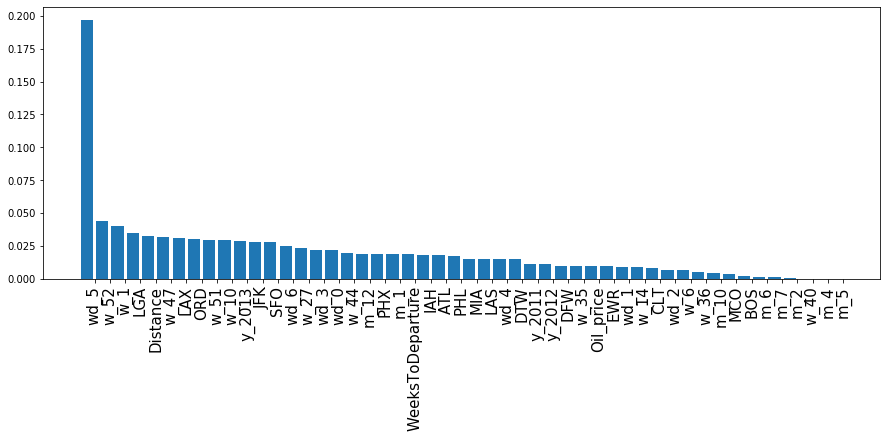

In [155]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(xgb1.feature_importances_)[::-1][:50]

importances = xgb1.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [22]:
data_dmatrix = xgb.DMatrix(data=X_encoded,label=y_array)
parameters = {'nthread':1,
              'objective':'reg:squarederror',
              'learning_rate': .2, 
              'max_depth': 7,
              'min_child_weight': 4,
              'subsample': 0.95,
              'colsample_bytree': 0.55,
              'n_estimators': 1000,
              'reg_lambda':0.001,
              'gamma':0}

cv_results = xgb.cv(dtrain=data_dmatrix, params=parameters, nfold=3,
                    num_boost_round=300,early_stopping_rounds=5,metrics="rmse", as_pandas=True, seed=123)

In [23]:
print((cv_results["train-rmse-mean"]).tail(1))
print((cv_results["test-rmse-mean"]).tail(1))

120    0.192126
Name: train-rmse-mean, dtype: float64
120    0.383942
Name: test-rmse-mean, dtype: float64


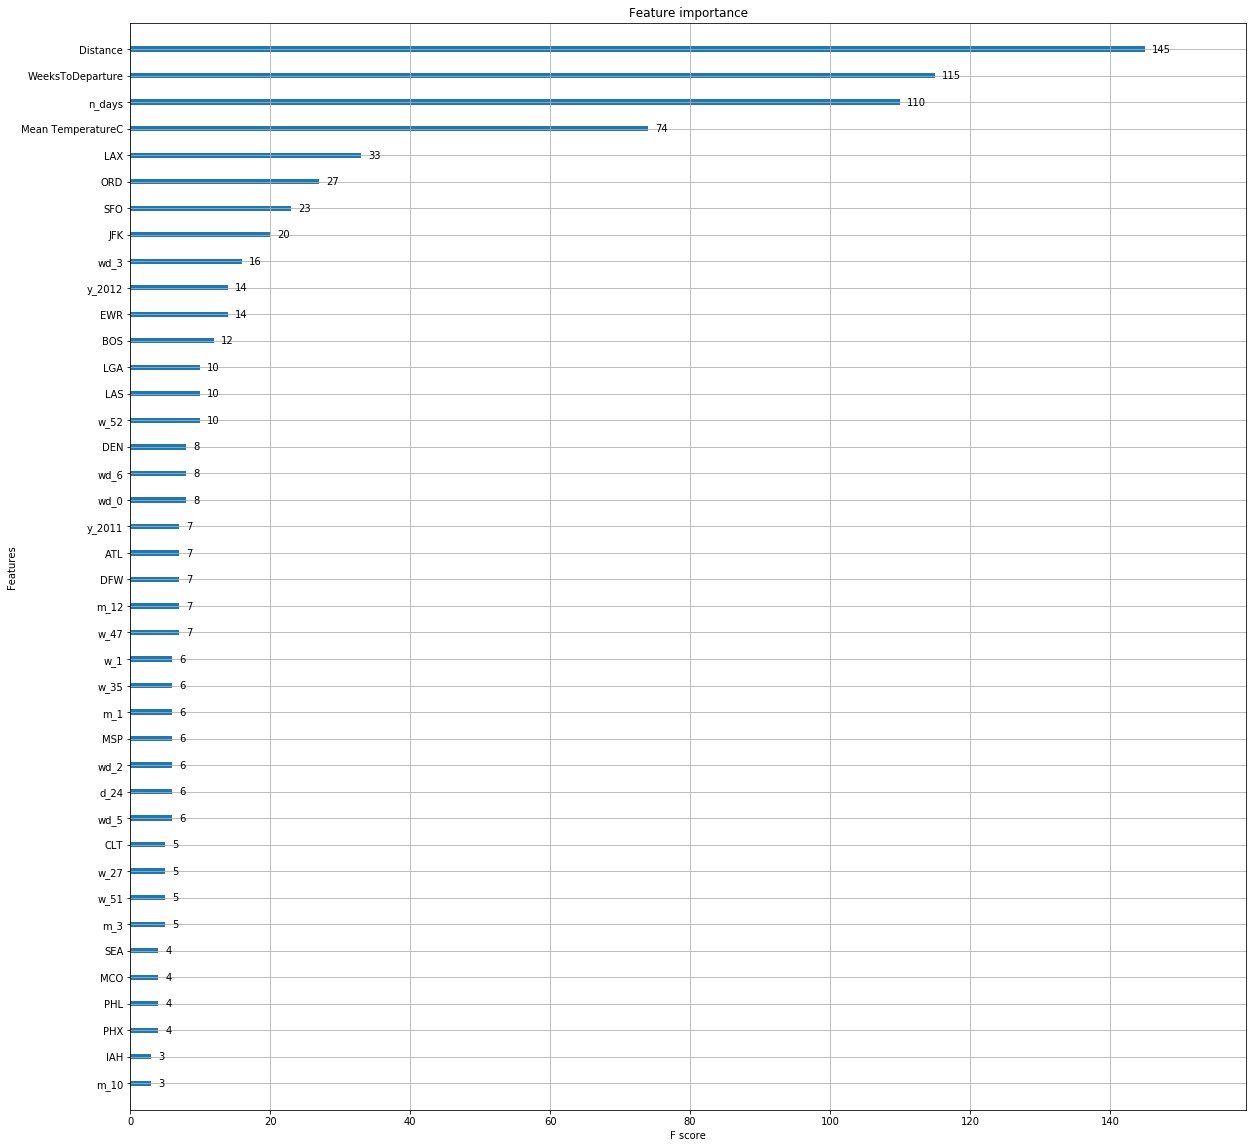

In [24]:
xg_reg = xgb.train(params=parameters, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg, max_num_features=40)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()